### Capstone project
Optmization: 
1. Try all the models only using the important features. It turns out both accuracy and Auc became worse
2. Try oversampling
There is decrease of accuracy after oversampling. However, auc score increased. More importantly, the F1 score significantly increased. Therefore it is better to try oversampling.
That's because this technique puts more weight to the small class, makes the model bias to it. The model will now predict the small class with higher accuracy but the overall accuracy will decrease.

In [ ]:
"""
Suppose you are looking at data from the general population to find people with a rare disease. 
There are far more people "negative" than "positive", and trying to optimize how well 
you are doing on the positive and the negative samples simultaneously, using AUC, is not optimal. 
You want the positive sample to include all positives if possible and you don't want it to be huge, 
due to a high false positive rate. So in this case you use the F1 score.

To put in very simple words when you have a data imbalance i.e., the difference between the number of examples 
you have for positive and negative classes is large, you should always use F1-score. 
Otherwise you can use ROC/AUC curves.
"""

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import numpy as np
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import IPython
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

%matplotlib inline

In [4]:
plt.rcParams["figure.figsize"] = (24,24) #in inches
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize']=13
plt.rcParams['ytick.labelsize']=13
plt.rcParams['legend.fontsize']=13
plt.rcParams['lines.linewidth']=2

In [72]:
drops=["ALP", "TB", "DB", "IB", "LDL", "Bun", "Gender"]
data = pd.read_excel('4304376.f1.xls', index_col=0)
data = data.drop(columns=drops)

In [73]:
data.head()

,Age,Height,Weight,ALT,AST,GGT,TC,TG,HDL,Cr,Glu,Uric,Ultrasound
Num,,,,,,,,,,,,,
2099,64,165.0,72.0,7.0,21.0,10.0,4.98,1.15,1.20,57.0,5.00,237.0,1
2109,54,170.0,74.0,17.0,22.0,23.0,4.77,1.91,1.19,74.0,5.74,339.0,1
2497,34,168.0,81.0,12.0,19.0,34.0,5.28,0.85,1.27,76.0,4.63,356.0,1
2982,42,169.0,70.0,20.0,25.0,35.0,5.24,1.68,1.52,64.0,4.95,281.0,1
2983,75,174.0,75.0,19.0,21.0,15.0,4.51,0.92,1.28,93.0,5.57,396.0,1


### because oversampling function does not allow null value, fill na first

In [81]:
columns = data.columns.to_list()

for column in columns:
    average = data[column].mean()
    data[column] = data[column].fillna(average)

### Oversampling

In [82]:
X = data.drop(columns="Ultrasound", axis=1)
y = data.Ultrasound

In [83]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X, y = ros.fit_sample(X, y)

## Split the whole data into train and test sets as 7 : 3

In [84]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify = y, random_state=42)

In [85]:
print("The size of train_set is: {}".format(X_train.shape[0]))
print("The size of test_set is: {}".format(X_test.shape[0]))

The size of train_set is: 11180
The size of test_set is: 4792


### Generate pipeline

In [86]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

In [87]:
pro_pipeline = Pipeline([
    ("scaler", StandardScaler())
])

In [88]:
X_train_prepared = pro_pipeline.fit_transform(X_train)
X_test_prepared = pro_pipeline.transform(X_test)

### Try the model of KNN

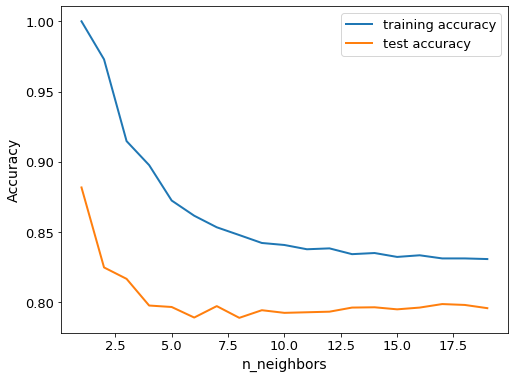

In [89]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()

training_accuracy = []
test_accuracy = []
# try n_neighbors from 1 to 10
n_neighbors_range = range(1, 20)

for i in n_neighbors_range:
    # build the model
    knn = KNeighborsClassifier(n_neighbors = i)
    knn.fit(X_train_prepared, y_train)
    # record training set accuracy
    training_accuracy.append(knn.score(X_train_prepared, y_train))
    # record generalization accuracy
    test_accuracy.append(knn.score(X_test_prepared, y_test))
plt.figure(figsize = (8, 6))    
plt.plot(n_neighbors_range, training_accuracy, label="training accuracy")
plt.plot(n_neighbors_range, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.legend()

In [90]:
knn = KNeighborsClassifier(n_neighbors = 15)
knn.fit(X_train_prepared, y_train)
print("KNN Training accuracy is: ", knn.score(X_train_prepared, y_train))
print("KNN Testing accuracy is: ", knn.score(X_test_prepared, y_test))

KNN Training accuracy is:  0.8322003577817532
KNN Testing accuracy is:  0.7948664440734557


KNN AUC:  0.8758311536199732


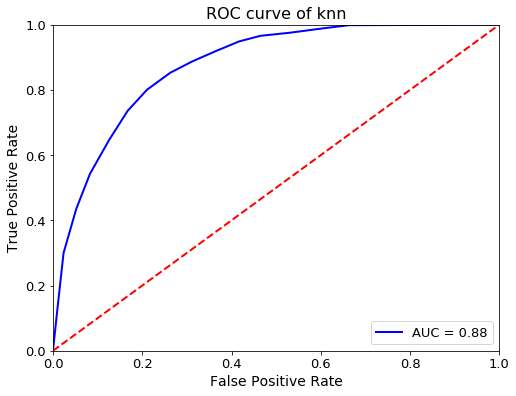

In [91]:
from sklearn import metrics
preds = knn.predict_proba(X_test_prepared)[:,1] # predicted probabilities generated by sklearn classifier
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
print("KNN AUC: ", roc_auc)

plt.figure(figsize = (8, 6)) 
plt.title('ROC curve of knn')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Try Naive Bayes modle

In [92]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(X_train_prepared, y_train)
print("NB Training accuracy is: ", nb.score(X_train_prepared, y_train))
print("NB Testing accuracy is: ", nb.score(X_test_prepared, y_test))

NB Training accuracy is:  0.7348837209302326
NB Testing accuracy is:  0.7291318864774624


In [93]:
preds = nb.predict_proba(X_test_prepared)[:,1] # predicted probabilities generated by sklearn classifier
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
print("NB AUC: ", roc_auc)

NB AUC:  0.8260827380637178


### Try Logistic model

In [94]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=100, penalty="l1")
logreg.fit(X_train_prepared, y_train)
print("Training accuracy is: ", logreg.score(X_train_prepared, y_train))
print("Testing accuracy is: ", logreg.score(X_test_prepared, y_test))

Training accuracy is:  0.8074239713774598
Testing accuracy is:  0.7975792988313857


/Users/pengl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [95]:
preds = logreg.predict_proba(X_test_prepared)[:,1] # predicted probabilities generated by sklearn classifier
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
print("NB AUC: ", roc_auc)

NB AUC:  0.879143313424433


## Try SVM

In [96]:
# C=1 IS BEETER THAN C=10
from sklearn.svm import SVC
svm = SVC(kernel = "rbf", C=1, gamma=0.1)
svm.fit(X_train_prepared, y_train)
print("Training accuracy is: ", svm.score(X_train_prepared, y_train))
print("Testing accuracy is: ", svm.score(X_test_prepared, y_test))

Training accuracy is:  0.8422182468694097
Testing accuracy is:  0.8130217028380634


In [97]:
# calculate svm auc score
preds = svm.decision_function(X_test_prepared) # predicted probabilities generated by sklearn classifier
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
print("SVM auc: ", roc_auc)

SVM auc:  0.8930871499800725


In [98]:
# C=1 IS BEETER THAN C=10
from sklearn.svm import LinearSVC
linear_svm = LinearSVC()
linear_svm.fit(X_train_prepared, y_train)
print("Training accuracy is: ", linear_svm.score(X_train_prepared, y_train))
print("Testing accuracy is: ", linear_svm.score(X_test_prepared, y_test))

Training accuracy is:  0.806618962432916
Testing accuracy is:  0.7965358931552587


/Users/pengl/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


### Try Decision Tree model

### Add the visualization of decision tree and feature_importances

In [99]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(random_state = 46, max_depth = 5)
tree.fit(X_train_prepared, y_train)
print("Training accuracy is: ", tree.score(X_train_prepared, y_train))
print("Testing accuracy is: ", tree.score(X_test_prepared, y_test))

Training accuracy is:  0.7929338103756708
Testing accuracy is:  0.7717028380634391


In [100]:
preds = tree.predict_proba(X_test_prepared)[:,1] # predicted probabilities generated by sklearn classifier
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
print("Tree AUC: ", roc_auc)

Tree AUC:  0.8441449786929245


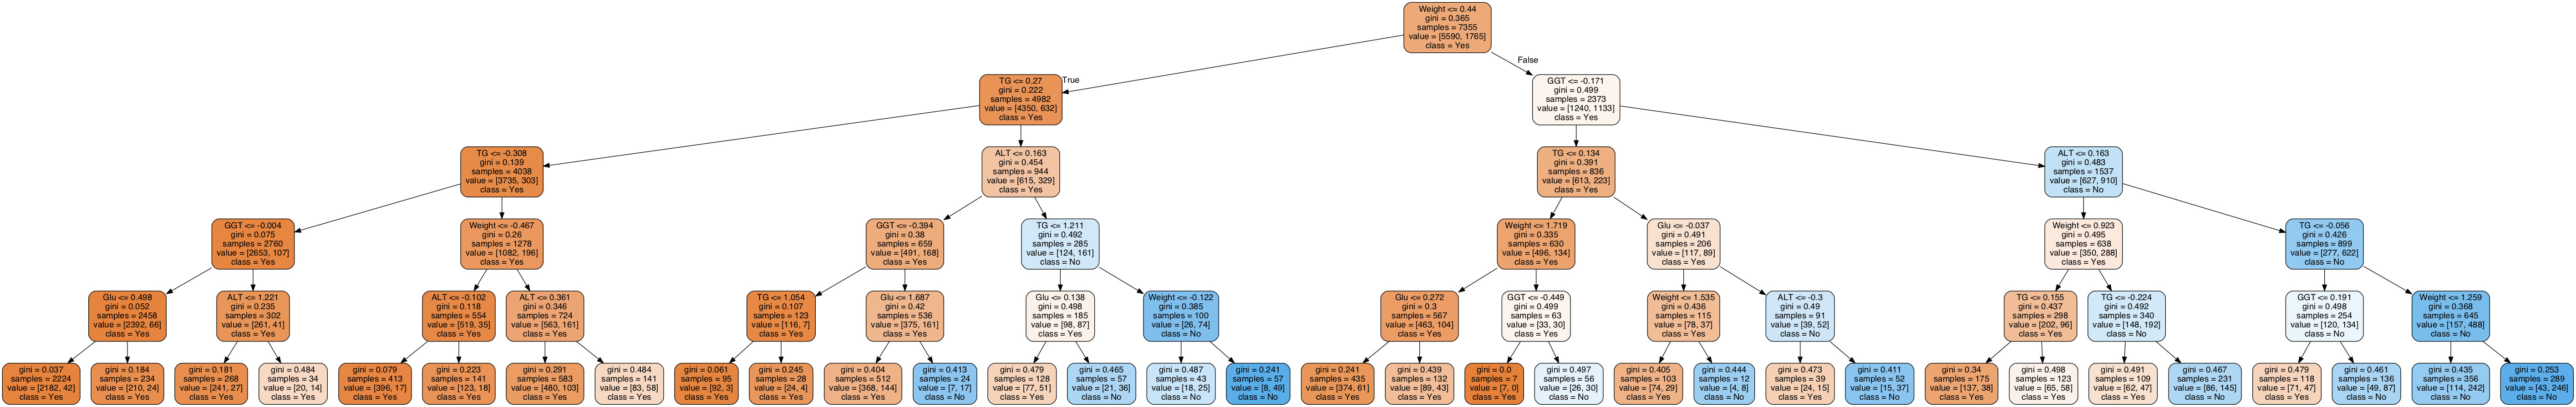

In [75]:
### JAME'S solution
from pydotplus import graph_from_dot_data
from sklearn.tree import export_graphviz
from IPython.display import Image


dot_data = export_graphviz(tree,
                           filled=True, 
                           rounded=True,
                           class_names=['Yes', 
                                        'No'],
                           feature_names=X_train.columns,
                           out_file=None) 

graph = graph_from_dot_data(dot_data) 

Image(graph.create_png()) 

In [317]:
# another method to display tree
from sklearn.tree import export_graphviz

export_graphviz(tree, out_file="NALD_tree.dot", feature_names = X_train.columns,
class_names = ['Yes', "No"], impurity=False, filled=True, rounded=True)

import graphviz

with open("NALD_tree.dot") as f: 
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

### Try the random Forest model

In [101]:
from sklearn.ensemble.forest import RandomForestClassifier
forest = RandomForestClassifier(n_estimators = 100, random_state = 46)
forest.fit(X_train_prepared, y_train)
print("Training accuracy is: ", forest.score(X_train_prepared, y_train))
print("Testing accuracy is: ", forest.score(X_test_prepared, y_test))

Training accuracy is:  1.0
Testing accuracy is:  0.9123539232053423


In [102]:
preds = forest.predict_proba(X_test_prepared)[:,1] # predicted probabilities generated by sklearn classifier
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
print("Tree AUC: ", roc_auc)

Tree AUC:  0.9819460334558712


### Try GradientBootsting

In [103]:
from sklearn.ensemble import GradientBoostingClassifier
gbrt = GradientBoostingClassifier(random_state = 0, max_depth =1)
gbrt.fit(X_train_prepared, y_train)
print("Training accuracy is: ", gbrt.score(X_train_prepared, y_train))
print("Testing accuracy is: ", gbrt.score(X_test_prepared, y_test))

Training accuracy is:  0.809660107334526
Testing accuracy is:  0.7936143572621035


In [104]:
preds = gbrt.predict_proba(X_test_prepared)[:,1] # predicted probabilities generated by sklearn classifier
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
print("Tree AUC: ", roc_auc)

Tree AUC:  0.8752113810998297


### Try gridSearchCV to fine tune parameters of logistic regression

### To prevent information leaking, add the whole pipe into gridSearchCV()

In [57]:
pipe = Pipeline([
    ('process', pro_pipeline),
    ('model', LogisticRegression()),
])

para_grid = [{'model__C': [0.1, 1, 10, 100]}]

In [58]:
from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(pipe, para_grid, cv=10, n_jobs=4)
grid_search.fit(X_train, y_train)  #Note here, do not use X_train_prepared and X_test_prepared

/Users/pengl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('process',
                                        Pipeline(memory=None,
                                                 steps=[('scaler',
                                                         StandardScaler(copy=True,
                                                                        with_mean=True,
                                                                        with_std=True))],
                                                 verbose=False)),
                                       ('model',
                                        LogisticRegression(C=1.0,
                                                           class_weight=None,
                                                           dual=False,
                                                           fit_intercept=True,
                                                    

In [59]:
print("Best accuracy is: ", grid_search.best_score_)
print("Best parameter is: ", grid_search.best_params_)

Best accuracy is:  0.7796064400715563
Best parameter is:  {'model__C': 0.1}


### Calculate F1 score

In [105]:
from sklearn.metrics import f1_score
models = [knn, logreg, nb, svm, tree, forest, gbrt]
model_names = ["knn", "logreg", "nb", "svm", "tree","forest", "gbrt"]
for i in range(len(models)):
    y_pred = models[i].predict(X_test_prepared)
    f1 =f1_score(y_test, y_pred, average='binary')
    print(model_names[i], "F1 score: ", f1)

knn F1 score:  0.8059996052891258
logreg F1 score:  0.8002471169686985
nb F1 score:  0.6878306878306878
svm F1 score:  0.8207282913165267
tree F1 score:  0.7803212851405622
forest F1 score:  0.9166335847558555
gbrt F1 score:  0.7998380894555758


### Calculate Auc

In [61]:
from sklearn import metrics

models2 = [knn, logreg, nb, tree, forest, gbrt]
model_names2 = ["knn", "logreg", "nb", "tree","forest", "gbrt"]
for i in range(len(models2)):
    preds_p = models2[i].predict_proba(X_test_prepared)[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds_p)
    roc_auc = metrics.auc(fpr, tpr)
    print(model_names2[i], "Auc: ", roc_auc)

knn Auc:  0.8712347480707334
logreg Auc:  0.865170678634571
nb Auc:  0.8484074178688622
tree Auc:  0.8568545195228181
forest Auc:  0.9778347055274841
gbrt Auc:  0.8736277186705582
